# Analysis of the online model

In [1]:
from __future__ import annotations

import os
import sys
sys.path.append(os.path.join(os.getcwd(), ".."))

import json
from typing import List

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

In [2]:
folder = '../data/online'
for filename in os.listdir(folder):
    if 'online' in filename:
        with open(f'{folder}/{filename}') as file:
            json_data = json.load(file)
            print(f'{filename}: {len(json_data)}')

batch_online_paper_r_s6_dt07-24_13-00-33.json: 1
batch_online_paper_r_s6_dt07-27_00-30-22.json: 20
batch_online_paper_r_s8_dt07-18_01-20-21.json: 4
batch_online_paper_r_s8_dt07-27_00-30-22.json: 20
batch_online_paper_r_s8_dt07-31_10-07-43.json: 20


In [3]:
results_filename = f'{folder}/batch_online_paper_r_s8_dt07-31_10-07-43.json'

with open(results_filename) as file:
    results_data = json.load(file)
    
results_data[0]['batch length 1'].keys()

dict_keys(['Greedy Utility * deadline / Sqrt Sum, Product, Pow percent sum', 'Fixed Greedy Utility * deadline / Sqrt Sum, Product'])

## Single model analysis

In [4]:
single_model_results = results_data[0]
for task in single_model_results['model']['tasks']:
    if 'auction time' not in task:
        task['auction time'] = 0
        
batch_lengths = [length for length in single_model_results if length != 'model']
batch_lengths

['batch length 1', 'batch length 2', 'batch length 4', 'batch length 6']

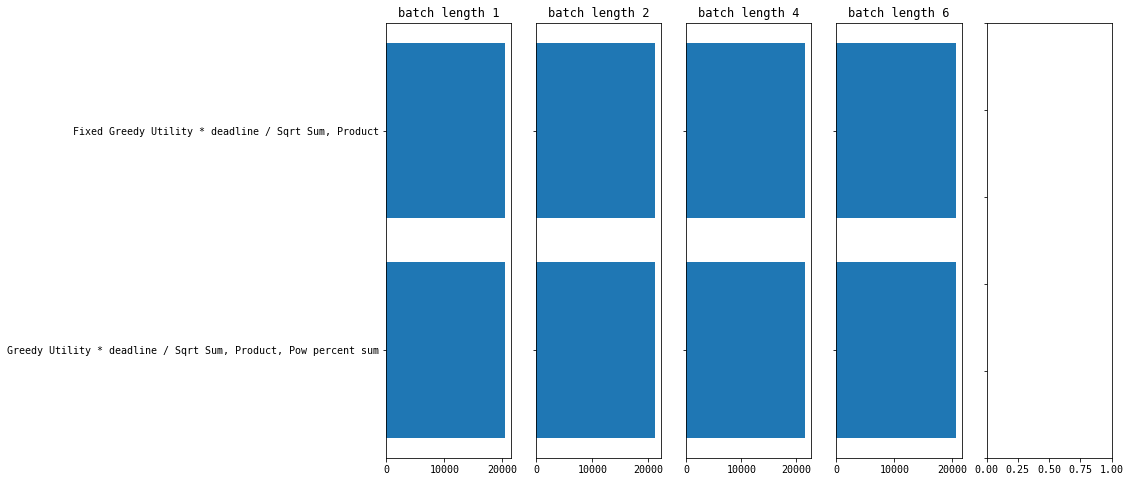

In [5]:
batch_fig, ax_batches = plt.subplots(1, 5, figsize=(13, 8))
algos = list(single_model_results['batch length 1'].keys())
for name, ax in zip(batch_lengths, ax_batches):
    ax.barh(algos, np.mean([single_model_results[name][algo]['social welfare'] for algo in algos]))
    ax.set_title(name)
    
for ax in ax_batches[1:]:
    plt.setp(ax.get_yticklabels(), visible=False)

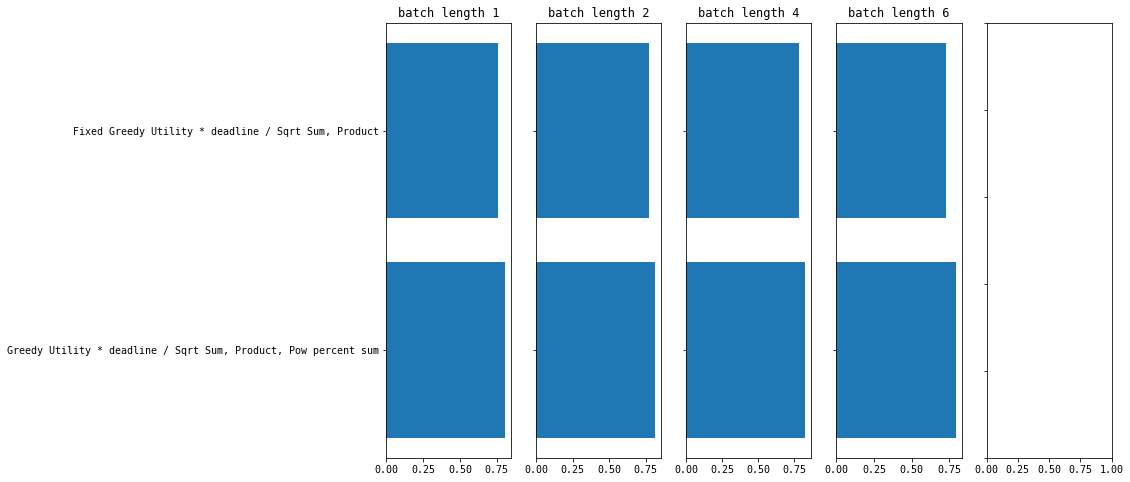

In [6]:
batch_fig, ax_batches = plt.subplots(1, 5, figsize=(13, 8))
algos = [name for name in single_model_results['batch length 1']]
for name, ax in zip(batch_lengths, ax_batches):
    ax.barh(algos, [np.mean([single_model_results[name][algo]['percentage tasks allocated']]) for algo in algos])
    ax.set_title(name)
    
for ax in ax_batches[1:]:
    plt.setp(ax.get_yticklabels(), visible=False)

### Task arrival over time

Text(0.5, 1.0, 'Task Arrival at each time step')

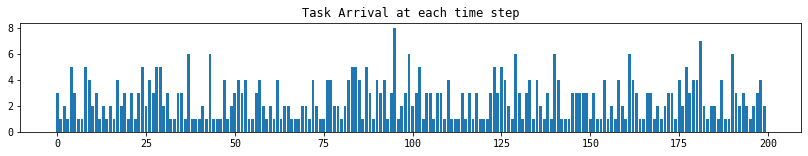

In [7]:
arrival_num = [
    sum(task['auction time'] == arrival_time for task in single_model_results['model']['tasks']) 
    for arrival_time in range(200)
]

_, ax_task_arrival = plt.subplots(figsize=(14, 2))
ax_task_arrival.bar(np.arange(200), arrival_num)
ax_task_arrival.set_title('Task Arrival at each time step')

### Resource batch results

In [8]:
def batch_resources(algo):
    batch_resource_fig, ax_batch_resources = plt.subplots(4, 3, figsize=(18, 10))
    batch_resource_fig.suptitle(algo, fontsize=15)
    
    ax_batch_resources[0][0].set_title('Server Storage Usage')
    ax_batch_resources[0][1].set_title('Server Computation Usage')
    ax_batch_resources[0][2].set_title('Server Bandwidth Usage')
    
    for (ax_batch_storage, ax_batch_computation, ax_batch_bandwidth), batch_len in zip(ax_batch_resources, batch_lengths):
        time_steps = len(single_model_results[batch_len][algo]['server storage used']['server 0'])
        algo_results = single_model_results[batch_len][algo]
        ax_batch_storage.plot(np.arange(time_steps), algo_results['server storage used']['server 0'])
        ax_batch_computation.plot(np.arange(time_steps), algo_results['server computation used']['server 0'])
        ax_batch_bandwidth.plot(np.arange(time_steps), algo_results['server bandwidth used']['server 0'])
        
        ax_batch_storage.set_ylabel(batch_len)

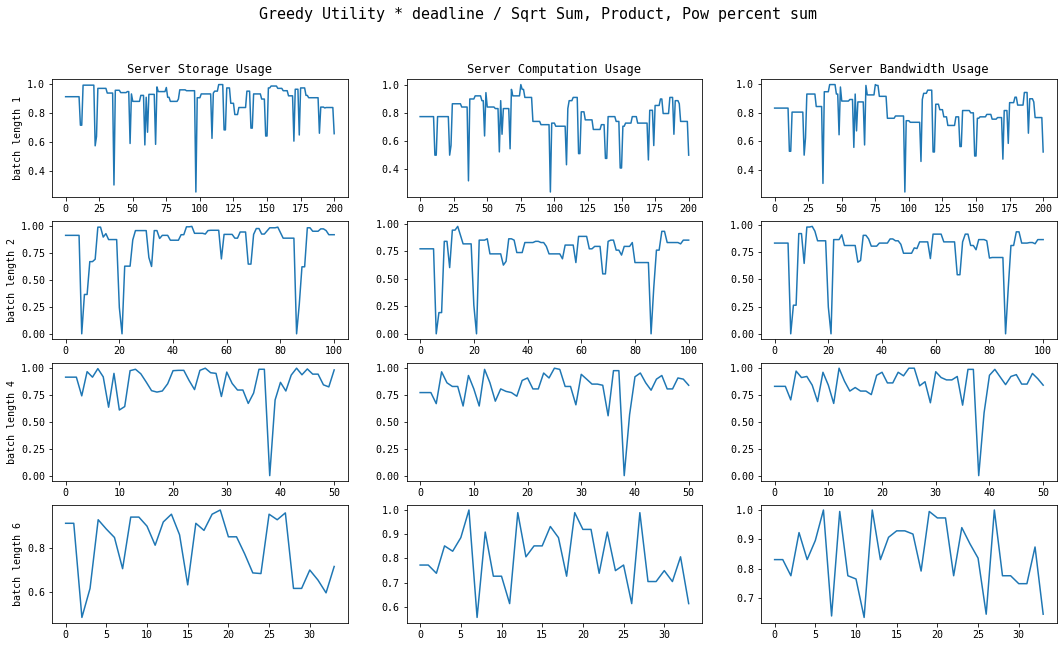

In [9]:
algo = next(name for name in single_model_results['batch length 1'].keys() if 'Greedy' in name)
batch_resources(algo)

## Overall results

Save file location: figs/online/eps/online_batch_lengths.eps
Save file location: figs/online/png/online_batch_lengths.png
Save file location: figs/online/pdf/online_batch_lengths.pdf


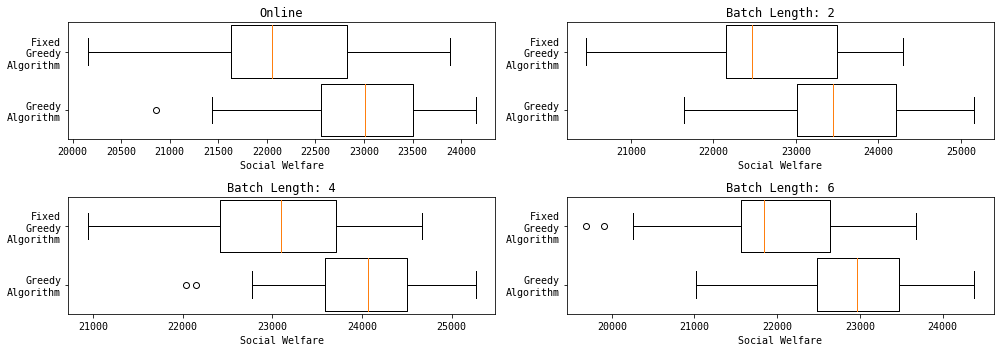

In [12]:
greedy_name = 'Greedy Utility * deadline / Sqrt Sum, Product, Pow percent sum'
fixed_greedy_name = 'Fixed Greedy Utility * deadline / Sqrt Sum, Product'

batch_results_fig, ax_batch_results = plt.subplots(2, 2, figsize=(14, 5))
ax_batch_results = ax_batch_results.flatten()
for batch_length, ax_batch_result in zip(batch_lengths[:4], ax_batch_results):
    data = [[], []]
    for result in results_data:
        data[1].append(result[batch_length][fixed_greedy_name]['social welfare'])
        data[0].append(result[batch_length][greedy_name]['social welfare'])
        
    ax_batch_result.boxplot(data, vert=False, widths=0.9)
    ax_batch_result.set_title(batch_length.replace('batch length ', 'Batch Length: '))
    ax_batch_result.set_xlabel('Social Welfare')
    ax_batch_result.set_yticklabels(['Greedy\nAlgorithm', 'Fixed\nGreedy\nAlgorithm'])
    
ax_batch_results[0].set_title('Online')
plt.tight_layout()
save_plot('online_batch_lengths', 'online')

In [11]:
print(f'Len 1: {np.mean([r["batch length 1"][greedy_name]["percentage tasks allocated"] for r in results_data])}')
print(f'Len 2: {np.mean([r["batch length 2"][greedy_name]["percentage tasks allocated"] for r in results_data])}')
print(f'Len 4: {np.mean([r["batch length 4"][greedy_name]["percentage tasks allocated"] for r in results_data])}')
print(f'Len 6: {np.mean([r["batch length 6"][greedy_name]["percentage tasks allocated"] for r in results_data])}')


Len 1: 0.8096
Len 2: 0.8166
Len 4: 0.8244499999999999
Len 6: 0.7759
